In [ ]:
#conda install hoomd
#pip install numpy matplotlib pymbar

In [1]:
import hoomd
import hoomd.md
import numpy as np
import matplotlib.pyplot as plt
from pymbar import MBAR

# Constants
kB = 1.380649e-23  # Boltzmann constant (J/K)
NA = 6.02214076e23  # Avogadro's number

# Initialize the system
#gpu = hoomd.device.GPU(gpu_id=0)  # Use GPU
sim = hoomd.Simulation(device=hoomd.device.CPU())
sim.seed = 42

Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.

****** PyMBAR will use 64-bit JAX! *******
* JAX is currently set to 32-bit bitsize *
* which is its default.                  *
*                                        *
* PyMBAR requires 64-bit mode and WILL   *
* enable JAX's 64-bit mode when called.  *
*                                        *
* This MAY cause problems with other     *
* Uses of JAX in the same code.          *
******************************************



In [2]:
# Define the simulation box and initial snapshot
box_size = 200  # e.g. 200 "units" wide, not necessarily real nm in HOOMD units
snap = hoomd.Snapshot()
snap.configuration.box = [box_size, box_size, box_size, 0, 0, 0]

# Create 1000 particles: 500 'benzene' + 500 'methane'
snap.particles.N = 1000
snap.particles.types = ['benzene', 'methane']
positions = np.random.uniform(-box_size / 2, box_size / 2, (1000, 3))
snap.particles.position[:] = positions
snap.particles.typeid[:500] = 0  # benzene
snap.particles.typeid[500:] = 1  # methane

# Initialize the simulation state from the snapshot
sim.create_state_from_snapshot(snap)

# ---------------------------------------------------------------------
# 2) Define forces and integrator
# ---------------------------------------------------------------------

# Set up an LJ pair force with a neighbor list
nl = hoomd.md.nlist.Cell(buffer=0.4)
lj = hoomd.md.pair.LJ(nlist=nl)

# Cutoffs
lj.r_cut[('benzene', 'benzene')] = 2.5
lj.r_cut[('methane', 'methane')] = 2.5
lj.r_cut[('benzene', 'methane')] = 2.5

# LJ parameters
lj.params[('benzene', 'benzene')] = dict(epsilon=1.0, sigma=1.0)
lj.params[('methane', 'methane')] = dict(epsilon=0.5, sigma=0.8)
lj.params[('benzene', 'methane')] = dict(epsilon=np.sqrt(1.0 * 0.5), sigma=0.9)

# Create the integrator
integrator = hoomd.md.Integrator(dt=0.001)
integrator.forces.append(lj)

# Set up an NVT ensemble using Berendsen thermostat
initial_temperature = 500  # in K, *not* automatically consistent with LJ
nvt = hoomd.md.methods.ConstantVolume(
    filter=hoomd.filter.All(),
    thermostat=hoomd.md.methods.thermostats.Berendsen(kT=initial_temperature, tau=0.1)
)

integrator.methods.append(nvt)
sim.operations.integrator = integrator

# Initialize velocities
sim.state.thermalize_particle_momenta(filter=hoomd.filter.All(), kT=initial_temperature)

In [3]:
# ---------------------------------------------------------------------
# 3) Equilibrate briefly
# ---------------------------------------------------------------------
sim.run(1e4)  # short MD run

In [4]:
# ---------------------------------------------------------------------
# 4) Utility functions: energy + wrapping
# ---------------------------------------------------------------------

def get_total_potential_energy(sim):
    """Compute the total potential energy by forcing a 0-step run and summing 'force.energy'."""
    sim.run(0)  # triggers energy computation
    total_energy = 0.0
    for f in sim.operations.integrator.forces:
        total_energy += f.energy
    return total_energy

def wrap_position(pos, box):
    """
    Wrap a 3D position into a periodic orthorhombic box.
    box.Lx, box.Ly, box.Lz are the box lengths in each dimension.
    """
    x, y, z = pos
    Lx, Ly, Lz = box.Lx, box.Ly, box.Lz
    # Shift from (-L/2, L/2) to [0, L), apply modulo, shift back.
    x = ((x + 0.5 * Lx) % Lx) - 0.5 * Lx
    y = ((y + 0.5 * Ly) % Ly) - 0.5 * Ly
    z = ((z + 0.5 * Lz) % Lz) - 0.5 * Lz
    return (x, y, z)

# ---------------------------------------------------------------------
# 5) Toy "Gibbs MC" style displacement moves
# ---------------------------------------------------------------------

def gibbs_ensemble_mc(sim, n_steps, temperature, max_displacement=0.1):
    """
    Illustrative MC routine:
      - Randomly selects a particle
      - Attempts a displacement
      - Accepts or rejects with a Metropolis criterion
    NOTE: Not a true GEMC approach (no volume or particle swaps).
    """
    for _ in range(int(n_steps)):
        snap = sim.state.get_snapshot()
        if snap.particles is None:
            # Could happen in MPI on non-root ranks
            continue

        N = snap.particles.N
        particle_idx = np.random.randint(0, N)

        old_position = snap.particles.position[particle_idx]
        displacement = np.random.uniform(-max_displacement, max_displacement, 3)
        new_position = old_position + displacement

        # Keep it in the box
        box = sim.state.box
        new_position = wrap_position(new_position, box)

        # Calculate old energy
        old_energy = get_total_potential_energy(sim)

        # Trial move
        snap.particles.position[particle_idx] = new_position
        sim.state.set_snapshot(snap)

        # Calculate new energy
        new_energy = get_total_potential_energy(sim)
        delta_energy = new_energy - old_energy

        # Metropolis acceptance
        # If HOOMD energies are dimensionless (LJ), you might need to
        # convert kB*T from real to dimensionless or vice versa.
        if delta_energy < 0:
            accept = True
        else:
            if np.random.rand() < np.exp(-delta_energy / (kB * temperature)):
                accept = True
            else:
                accept = False

        # Revert if rejected
        if not accept:
            snap = sim.state.get_snapshot()
            if snap.particles is not None:
                snap.particles.position[particle_idx] = old_position
                sim.state.set_snapshot(snap)

# ---------------------------------------------------------------------
# 6) Compute VLE-like properties
# ---------------------------------------------------------------------

def calculate_vle_properties(sim, temperatures, pressures):
    """
    Runs MD + toy "Gibbs" moves at each (T, P), then "computes" average z positions
    as stand-ins for densities. Real code would do actual dens. calculations.
    """
    densities_liquid = []
    densities_vapor = []

    for T, P in zip(temperatures, pressures):
        # Set temperature; you might also set up a barostat for pressure if needed
        nvt.thermostat.kT = T

        # Run some MD to re-equilibrate
        sim.run(1e4)

        # Run the MC moves
        gibbs_ensemble_mc(sim, n_steps=1000, temperature=T)

        # Retrieve snapshot and "measure"
        snap = sim.state.get_snapshot()
        if snap.particles is None:
            # Non-root MPI rank
            densities_liquid.append(0.0)
            densities_vapor.append(0.0)
        else:
            pos = snap.particles.position
            # The user previously took the "liquid" as the first 500 (benzene)
            # and "vapor" as the last 500 (methane).
            # We simply average their z-coordinates (NOT real densities!)
            z_coords_benzene = pos[:500, 2]
            z_coords_methane = pos[500:, 2]

            density_liquid = np.mean(z_coords_benzene)
            density_vapor = np.mean(z_coords_methane)

            densities_liquid.append(density_liquid)
            densities_vapor.append(density_vapor)

    return densities_liquid, densities_vapor

# ---------------------------------------------------------------------
# 7) Plotting the results
# ---------------------------------------------------------------------

def plot_vle_diagram(temperatures, pressures, densities_liquid, densities_vapor):
    plt.figure(figsize=(8, 6))
    plt.plot(temperatures, pressures, 'o-', label='VLE Curve')
    plt.xlabel('Temperature (K)')
    plt.ylabel('Pressure (atm)')
    plt.title('Vapor-Liquid Equilibrium Phase Diagram (Toy Example)')
    plt.grid(True)
    plt.legend()
    plt.show()

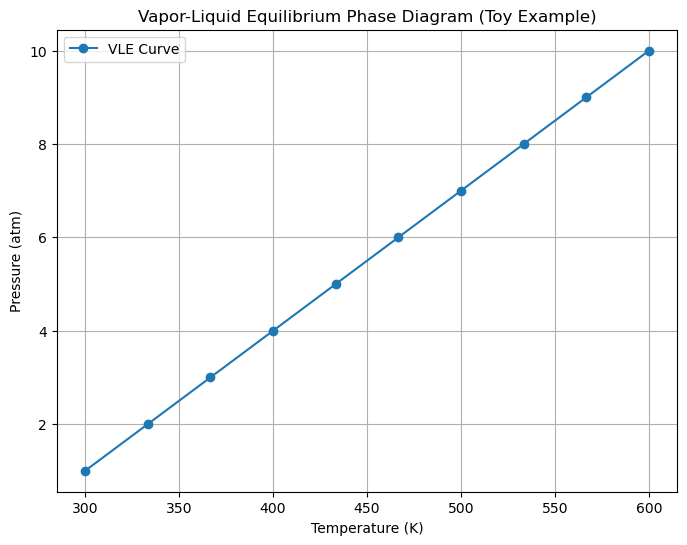

In [5]:
temperatures = np.linspace(300, 600, 10)  # 300..600 K in 10 steps
pressures = np.linspace(1, 10, 10)        # 1..10 atm in 10 steps (unused except for plot label)

densities_liquid, densities_vapor = calculate_vle_properties(sim, temperatures, pressures)

plot_vle_diagram(temperatures, pressures, densities_liquid, densities_vapor)